In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import matplotlib.pyplot as plt
from collections import Counter
import MeCab

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAGothic'

In [2]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)
    
clue_word_entropy = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

In [3]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train = train.loc[train.sentence.str.contains("|".join(clue_word_by_BS))].reset_index(drop=True)
print("train length (filtering) :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train length : 6671
label 1 : 1514 	label 0 : 5157
train length (filtering) : 3341
label 1 : 1045 	label 0 : 2296


In [4]:
# 文中に各手がかり語が含まれているどうかの特徴量を作成

feature_word_dict = {}

for word in np.append(clue_word_entropy, ['用途', '効果', '目的', '用い', '使わ']):
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [5]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word_entropy, ['用途', '効果', '目的']))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

train.heading_cat = train.heading_cat.astype('category') 

In [ ]:
# 文中にカテゴリ名が含まれているどうか
category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

In [6]:
# 文中にカテゴリ名・記事タイトル名と一致する名詞が含まれているどうか
noun_list = '|'.join(pd.read_csv("../data/noun_list_in_category_and_title.csv").noun.values)
is_noun_cat = train.sentence.str.contains(noun_list).tolist()

## 学習

In [7]:
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_noun_cat = is_noun_cat
)
train_y = train.label.tolist()

In [8]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.6876232300899103
precision:  0.6884738894617236
recall:  0.6899521531100478


In [37]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        **params
    )
    
    score = cross_validate(clf, train_X, train_y, scoring='f1', cv=5)['test_score'].mean()
    print("f1 {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf',  5, 25, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

best = fmin(fn=objective
            ,space=space
            ,algo=tpe.suggest
            ,max_evals=50
           )

f1 0.681 params {'num_leaves': 170, 'colsample_bytree': '0.632'}
f1 0.681 params {'num_leaves': 130, 'colsample_bytree': '0.622'}
f1 0.681 params {'num_leaves': 150, 'colsample_bytree': '0.548'}
f1 0.686 params {'num_leaves': 60, 'colsample_bytree': '0.794'}
f1 0.686 params {'num_leaves': 170, 'colsample_bytree': '0.747'}
f1 0.685 params {'num_leaves': 140, 'colsample_bytree': '0.865'}
f1 0.681 params {'num_leaves': 140, 'colsample_bytree': '0.502'}
f1 0.686 params {'num_leaves': 170, 'colsample_bytree': '0.764'}
f1 0.686 params {'num_leaves': 80, 'colsample_bytree': '0.780'}
f1 0.685 params {'num_leaves': 160, 'colsample_bytree': '0.891'}
f1 0.686 params {'num_leaves': 90, 'colsample_bytree': '0.771'}
f1 0.683 params {'num_leaves': 80, 'colsample_bytree': '0.637'}
f1 0.686 params {'num_leaves': 70, 'colsample_bytree': '0.803'}
f1 0.687 params {'num_leaves': 160, 'colsample_bytree': '0.715'}
f1 0.687 params {'num_leaves': 190, 'colsample_bytree': '0.668'}
f1 0.685 params {'num_leaves':

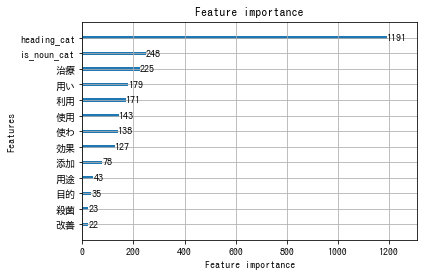

In [40]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [44]:
predict = model.predict(train_X)

TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

print(train.loc[TP_index, 'sentence'].values)

In [49]:
train.loc[TP_index, ['_id', 'sentence']].to_csv("positive_sentence.csv", index=False)